# Seurat - Guided Clustering Tutorial
元URL: https://satijalab.org/seurat/articles/pbmc3k_tutorial.html

(最終更新 2021/3/17)

## Setup the Seurat Object

- このチュートリアルでは、10X Genomicsから自由に入手できる末梢血単核細胞（PBMC, 2,700 cells）のデータセットを解析します。
- `Read10X`関数は、10Xから cellranger pipeline の出力を読み込んで、UMIマトリックスを返します。
- このUMIマトリックスを使用して、Seuratオブジェクトを作成します。このオブジェクトは、scRNA-seqデータ（UMIマトリックス）と解析（PCAやクラスタリング結果）の両方を格納するコンテナとしての役割を果たします。

以下のコマンドはR上で実行します。

In [1]:
# ライブラリ読み込み
library(dplyr)
library(Seurat)
library(patchwork)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject



## バージョンの確認
`sessionInfo()`コマンドを使って今読み込んでいるライブラリのバージョンを確認します。エラーの多くは古いバージョンなどを使っていることに起因しますので、常にバージョンを確認する癖をつけておきましょう。ここでは R version 4.0.3, Seuratのバージョンは4.0.0 です。

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.1.1    SeuratObject_4.0.0 Seurat_4.0.0       dplyr_1.0.4       

loaded via a namespace (and not attached):
  [1] nlme_3.1-151         matrixStats_0.58.0   RcppAnnoy_0.0.18    
  [4] RColorBrewer_1.1-2   httr_1.4.2           repr_1.1.3          
  [7

## データ読み込み
PBMCのデータ2700細胞を読み込みます。ここでは10Xで生成されたデータをそのまま読み込めるRead10Xコマンドを利用しています。
入力データとして、filtered_gene_bc_matrices 内の hg19 フォルダを指定します。

発現細胞数、遺伝子数でフィルタ後のSeuratオブジェクトを確認すると、2700細胞 × 13714遺伝子の行列データになっていることがわかります。

In [3]:
# Load the PBMC dataset (cellrangerのraw dataを読み込み、UMIの行列に変換)
pbmc.data <- Read10X(data.dir = "./filtered_gene_bc_matrices/hg19/")

# Initialize the Seurat object with the raw (non-normalized data).
# min.cells, min.features はそれぞれ最低発現細胞数、遺伝子数
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

カウント行列の中身を閲覧するには、`pbmc[["RNA"]]@counts` または `pbmc.data` と指定します。
この２つはいずれもUMI値ですが遺伝子の並び順は異なるようです。

UMI値を表示した時のドットは発現量が0であることを表します。sparse-matrix representationによってメモリ使用量を抑えています。

In [4]:
# 最初の20細胞中の冒頭10遺伝子についてUMI値を表示
pbmc[["RNA"]]@counts[1:10,1:20]
# pbmc.data[1:10,1:20]  でも同じ（並び順は異なる）

   [[ suppressing 20 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



10 x 20 sparse Matrix of class "dgCMatrix"
                                                     
AL627309.1    . . . . . . . . . . . . . . . . . . . .
AP006222.2    . . . . . . . . . . . . . . . . . . . .
RP11-206L10.2 . . . . . . . . . . . . . . . . . . . .
RP11-206L10.9 . . . . . . . . . . . . . . . . . . . .
LINC00115     . . . . . . . . . . . . . . . . . . . .
NOC2L         . . . . . . . . . . . 1 . . . . . . . .
KLHL17        . . . . . . . . . . . . . . . . . . . .
PLEKHN1       . . . . . . . . . . . . . . . . . . . .
RP11-54O7.17  . . . . . . . . . . . . . . . . . . . .
HES4          . . . . . . . . . . . . . . . . . . 1 .

In [7]:
# 特定の遺伝子について、冒頭30細胞におけるUMI値を表示
# pbmc.data["CD3D", 1:30]  # 1遺伝子の場合
pbmc.data[c("CD3D", "TCL1A", "MS4A1"), 1:30]  # 複数遺伝子を指定する場合

   [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

## 前処理

- 以下では、Seuratでの scRNA-seq データの標準的な前処理ワークフロー（品質評価(QC)、細胞フィルタリング、データ正規化・スケーリング、高変動遺伝子の抽出）を行います。
- Seuratでは以下の基準に基づいてQC・細胞フィルタリングをします。

    - 各細胞で検出された発現遺伝子数
        
        - 低品質の細胞や空の液滴は、多くの場合、非常に少ない遺伝子数になります。
        - 細胞のダブレットまたはマルチプレットは、異常に高い遺伝子数を示すことがあります。
    - 細胞内で検出された総分子数（発現遺伝子数と強く相関するはず）
    - ミトコンドリアゲノムにマップするリードの割合
    
        - 低品質/死細胞は、しばしば高いミトコンドリアの値となります。
        - ミトコンドリアの QC メトリクスは `PercentageFeatureSet` 関数を使用して計算します。

- ここでは遺伝子名が`MT-` で始まる遺伝子をミトコンドリアRNAとみなしています。
- 以下ではその値を "percent.mt" という列名でpbmcオブジェクトに新たに追加します。

In [9]:
# 以下のコマンドで、pbmcオブジェクトのメタデータに"percent.mt"カラムを追加することができます。
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

QCの値はpbmc@meta.dataに格納されます。
**percent.mt**の他、**nCount**: 総UMI数, **nFeature**: 発現遺伝子数、の値が格納されています。

In [10]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


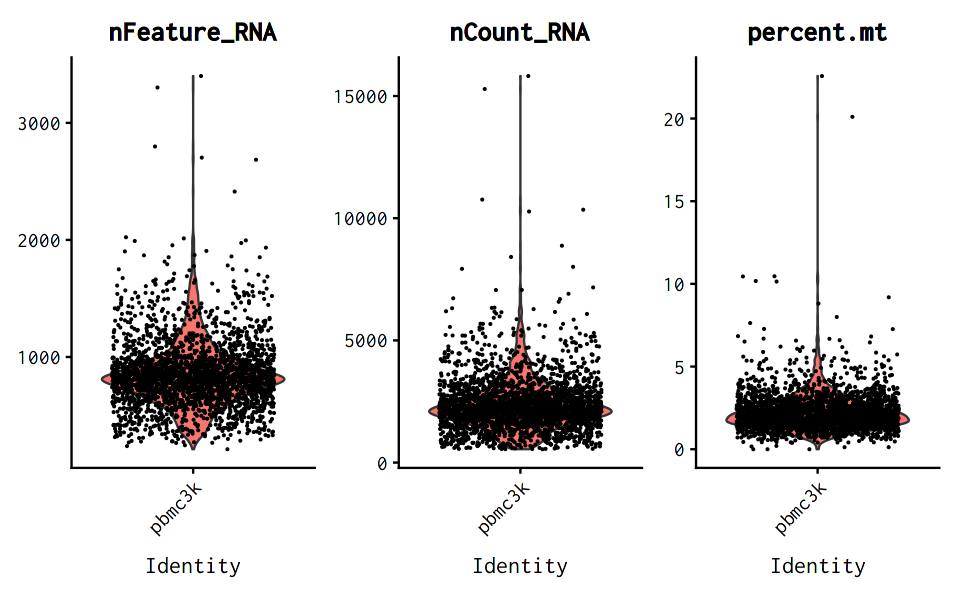

In [12]:
# violin plotでQC値の分布を表示
options(repr.plot.width = 8, repr.plot.height = 5) # Jupyter上での図のサイズを変更
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0.1)

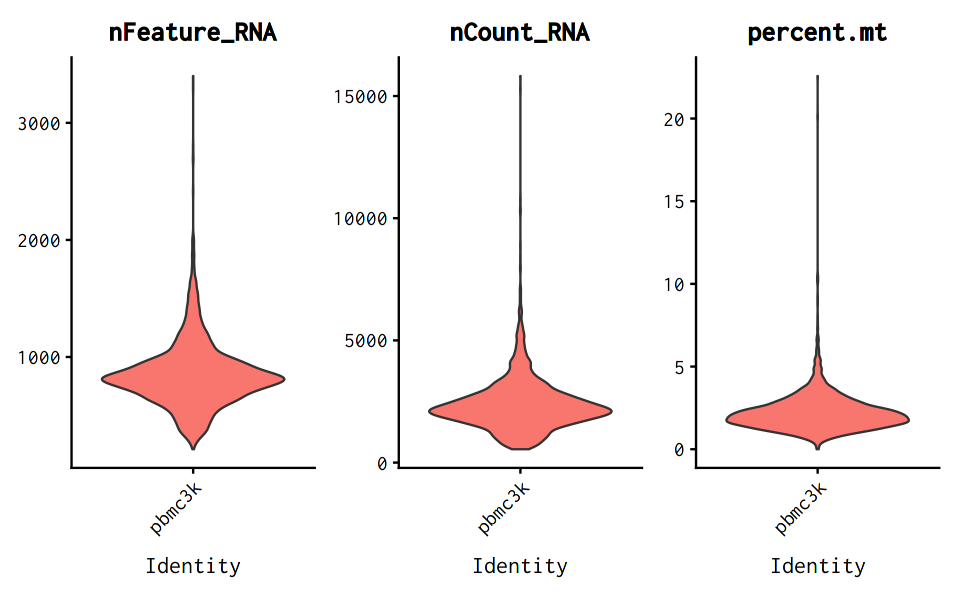

In [15]:
# 点を消したい場合は pt.size = 0 とする
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, pt.size = 0)

以下では二種類のQC値をX,Y軸に置いた散布図としてプロットしています。
これにより、「UMI値に対して発現遺伝子数が少なすぎる」というような細胞を検出することができます。

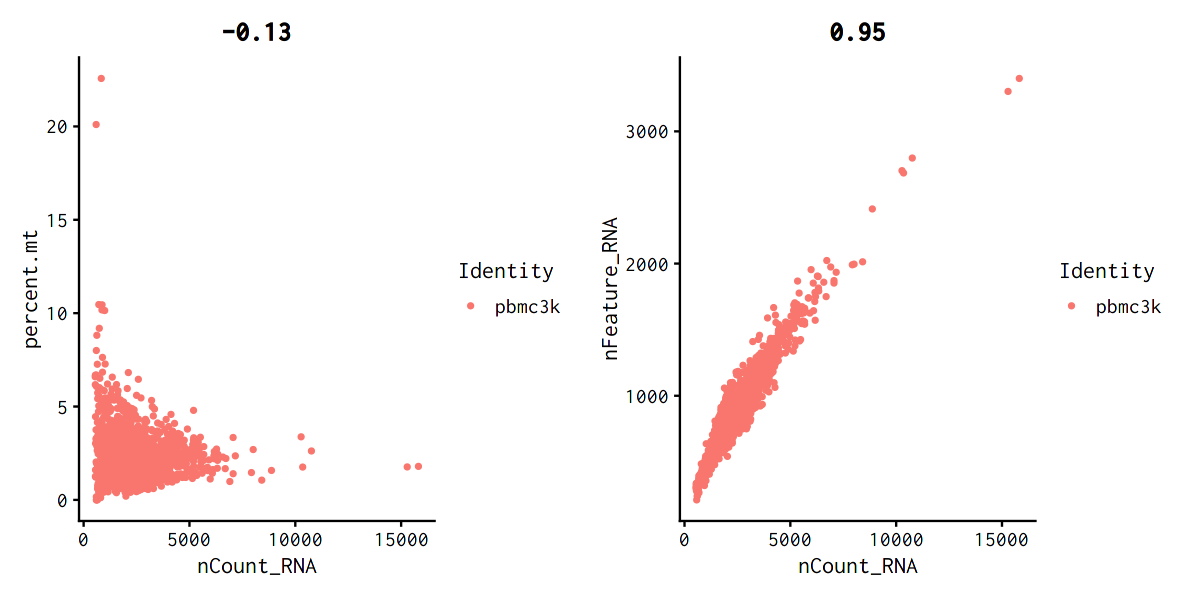

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5)
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

以下のコマンドでは実際におかしな値を持つ細胞をフィルタしています。

**subset**　コマンドは、**=** 以後の条件を満たす細胞だけを返します。
'条件1 & 条件2' は「条件１かつ条件２」を示します。

In [17]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

## 正規化

デフォルトでは"**LogNormalize**"を採用しており、細胞ごとの総UMI数が10,000になるように正規化し、結果をlog変換します。正規化された値はpbmc[["RNA"]@dataに格納されます。

（作成者注：scRNA-seqツールの中には、**正規化後の行列**を要求するものと**正規化前の行列**を要求するものがありますので、自分が今どちらのデータを扱っているかは常に意識しておく必要があります。Seuratは対数変換された正規化行列を以降の解析で用います。）

In [18]:
#pbmc <- NormalizeData(pbmc)
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000) #でも同じ

### Highly variable genes (HVGs) の抽出 （特徴選択）

- クラスタリング解析においては、細胞間で「発現量に対して細胞ごとの変動（分散）が大きい遺伝子 (**Highly variable genes**)」 が基本的な興味の対象となります。
- Seurat3では`FindVariableFeatures`関数で実装されています。ここでは、特に分散の大きい 2,000遺伝子のみを抽出して残りは削除するという操作を行います。

（作成者注：これは前述の細胞フィルタリングとは異なり、主に計算量を削減するための操作です。従ってマシンパワーが許すならこの操作を行わなくても構いませんが、HVGsのみを抽出して解析しても結果には大きな影響はないとされています）。

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“CombinePlots is being deprecated. Plots should now be combined using the patchwork system.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


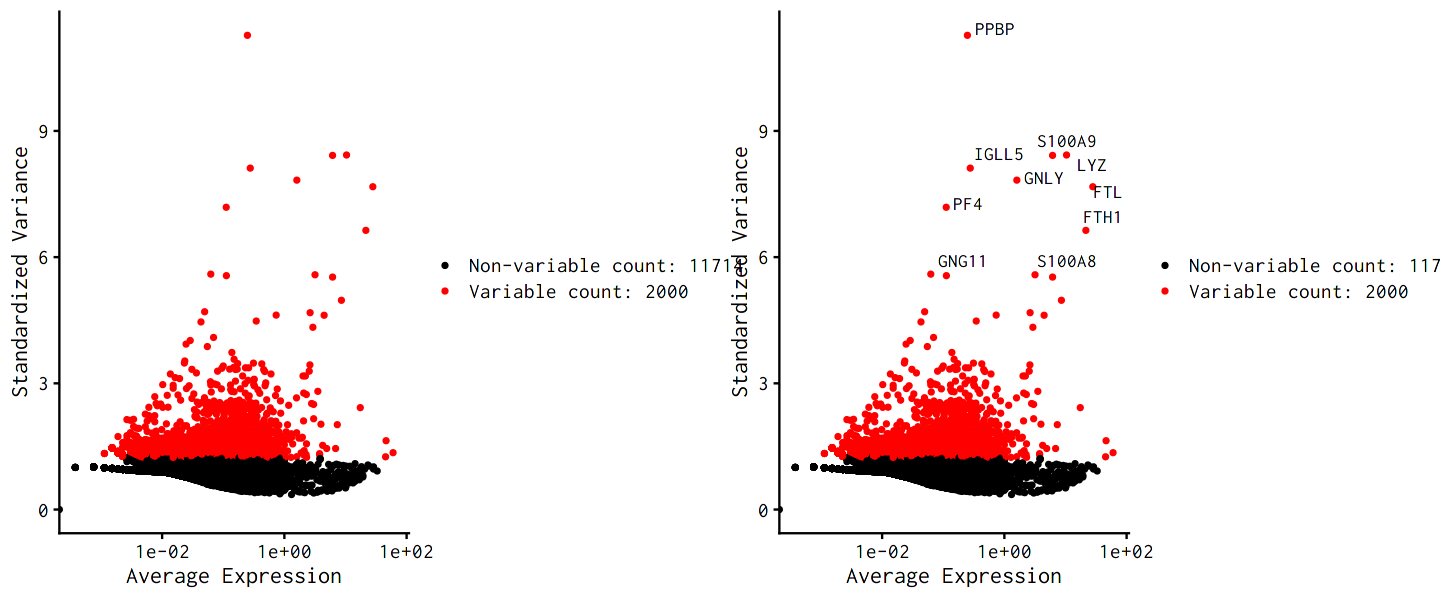

In [19]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# 上位10個のHVGsをtop10に格納
top10 <- head(VariableFeatures(pbmc), 10)

options(repr.plot.width = 12, repr.plot.height = 5)
# HVGsを赤色として「発現量ー分散」の散布図をプロット
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
#plot1 + plot2   # エラーになるのでCombinePlotsを使う
CombinePlots(plots = list(plot1, plot2))

## データスケーリング

（作成者注：Seuratでは正規化 (normalization)と線形変換 (scaling)は別物として定義している。）

`ScaleData`関数により、全細胞に対し、発現量の平均が0、分散が1になるようにスケーリングします。結果は`pbmc[["RNA"]]@scale.data`に格納されます。


In [20]:
all.genes <- rownames(pbmc)

# ここでは全遺伝子を使ってスケーリングします。
pbmc <- ScaleData(pbmc, features = all.genes)

# HVGsだけを使ってスケーリングする場合：
# pbmc <- ScaleData(pbmc)   

Centering and scaling data matrix



## PCAによる次元削減
各細胞は遺伝子数の要素（次元）を持っており、これは通常下流解析には多すぎる次元数です。そこでPCAによる**次元削減**を行い、細胞がもつ情報をできるだけ失うことなく次元数を圧縮します。

PCA（主成分分析）における次元削減とは簡単に言えば、３次元の風景の写真を撮ると、2次元の画像に変換されるということと考え方は同じです。３次元の風景の要素を可能な限り残したまま２次元にする、という作業が、適切な（寄与率の高い）主成分（PC1, PC2）を選択していることになります。一方tSNE, UMAPは非線形変換なので、変換後の要素の配置は変換前と異なるものになります。

### PCA

In [22]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
# コマンドを実行すると、PC5までの主成分の軸に対して大きな値を持つ遺伝子が表示されます。

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

### 意味のある次元数の推定
「元データの情報量を十分表現する次元（主成分）の数」を確かめるため、いくつかの方法を用います。

（作成者注：実際にはデフォルトの第10主成分まででよいことが多く、特に気にならなければこれらの工程はスキップしても問題ありません。）

#### PC1からPC5までの上位・下位トップランク遺伝子を表示

In [23]:
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, SDPR, PF4, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, S100A8, NKG7, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


#### PC1, PC2について同様に図で表示

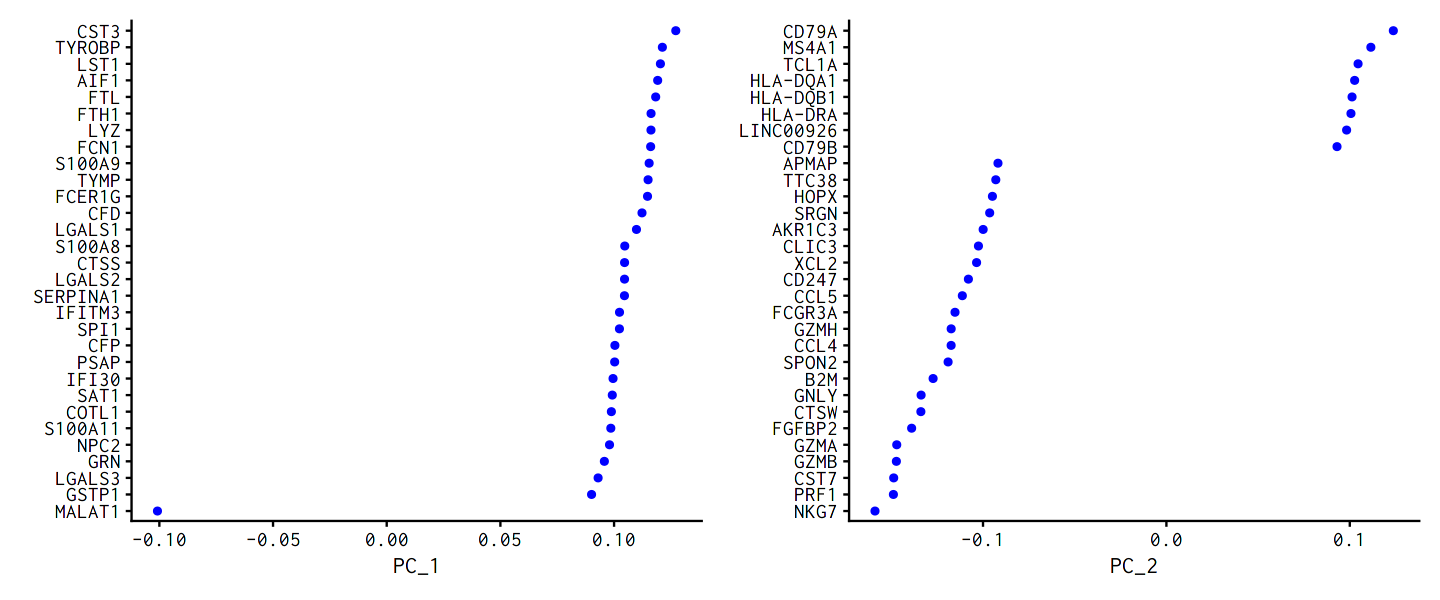

In [24]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

#### PC1, PC2の散布図表示

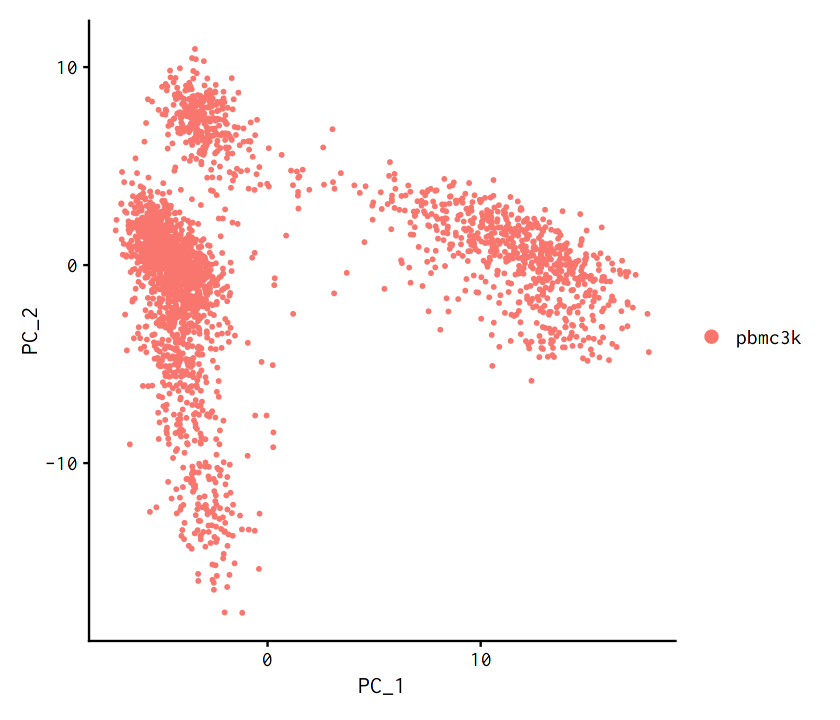

In [25]:
options(repr.plot.width = 7, repr.plot.height = 6)
DimPlot(pbmc, reduction = "pca")

#### PC1方向で正負トップランクの遺伝子について、ランダムに選ばれたそれぞれ500細胞での値を可視化

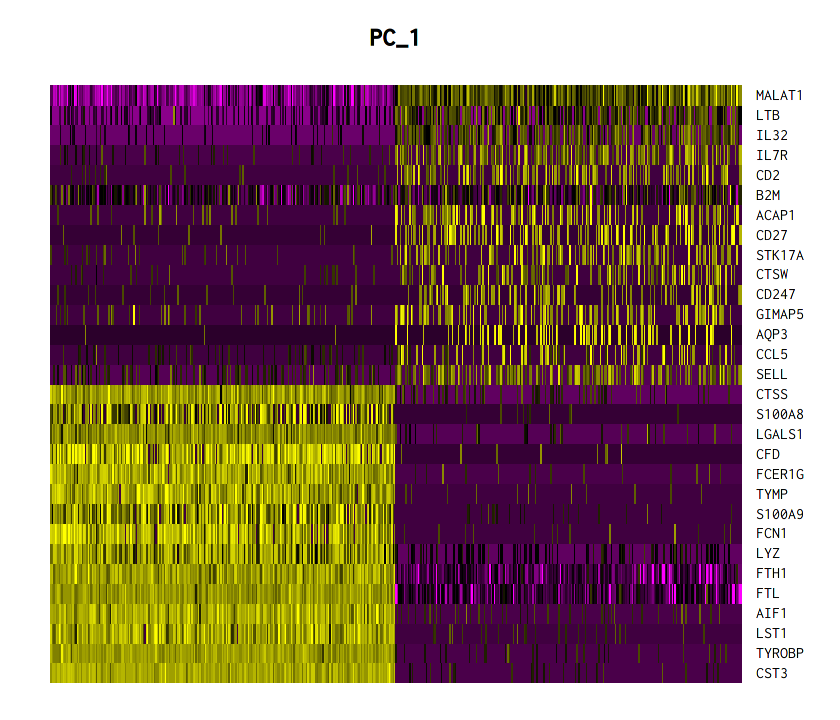

In [26]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

#### PC15までを一度に可視化 
- 目で見る主観的な方法だが有用性が高い
- 二分されているように見えなければ、その主成分にはもう情報がないと言える


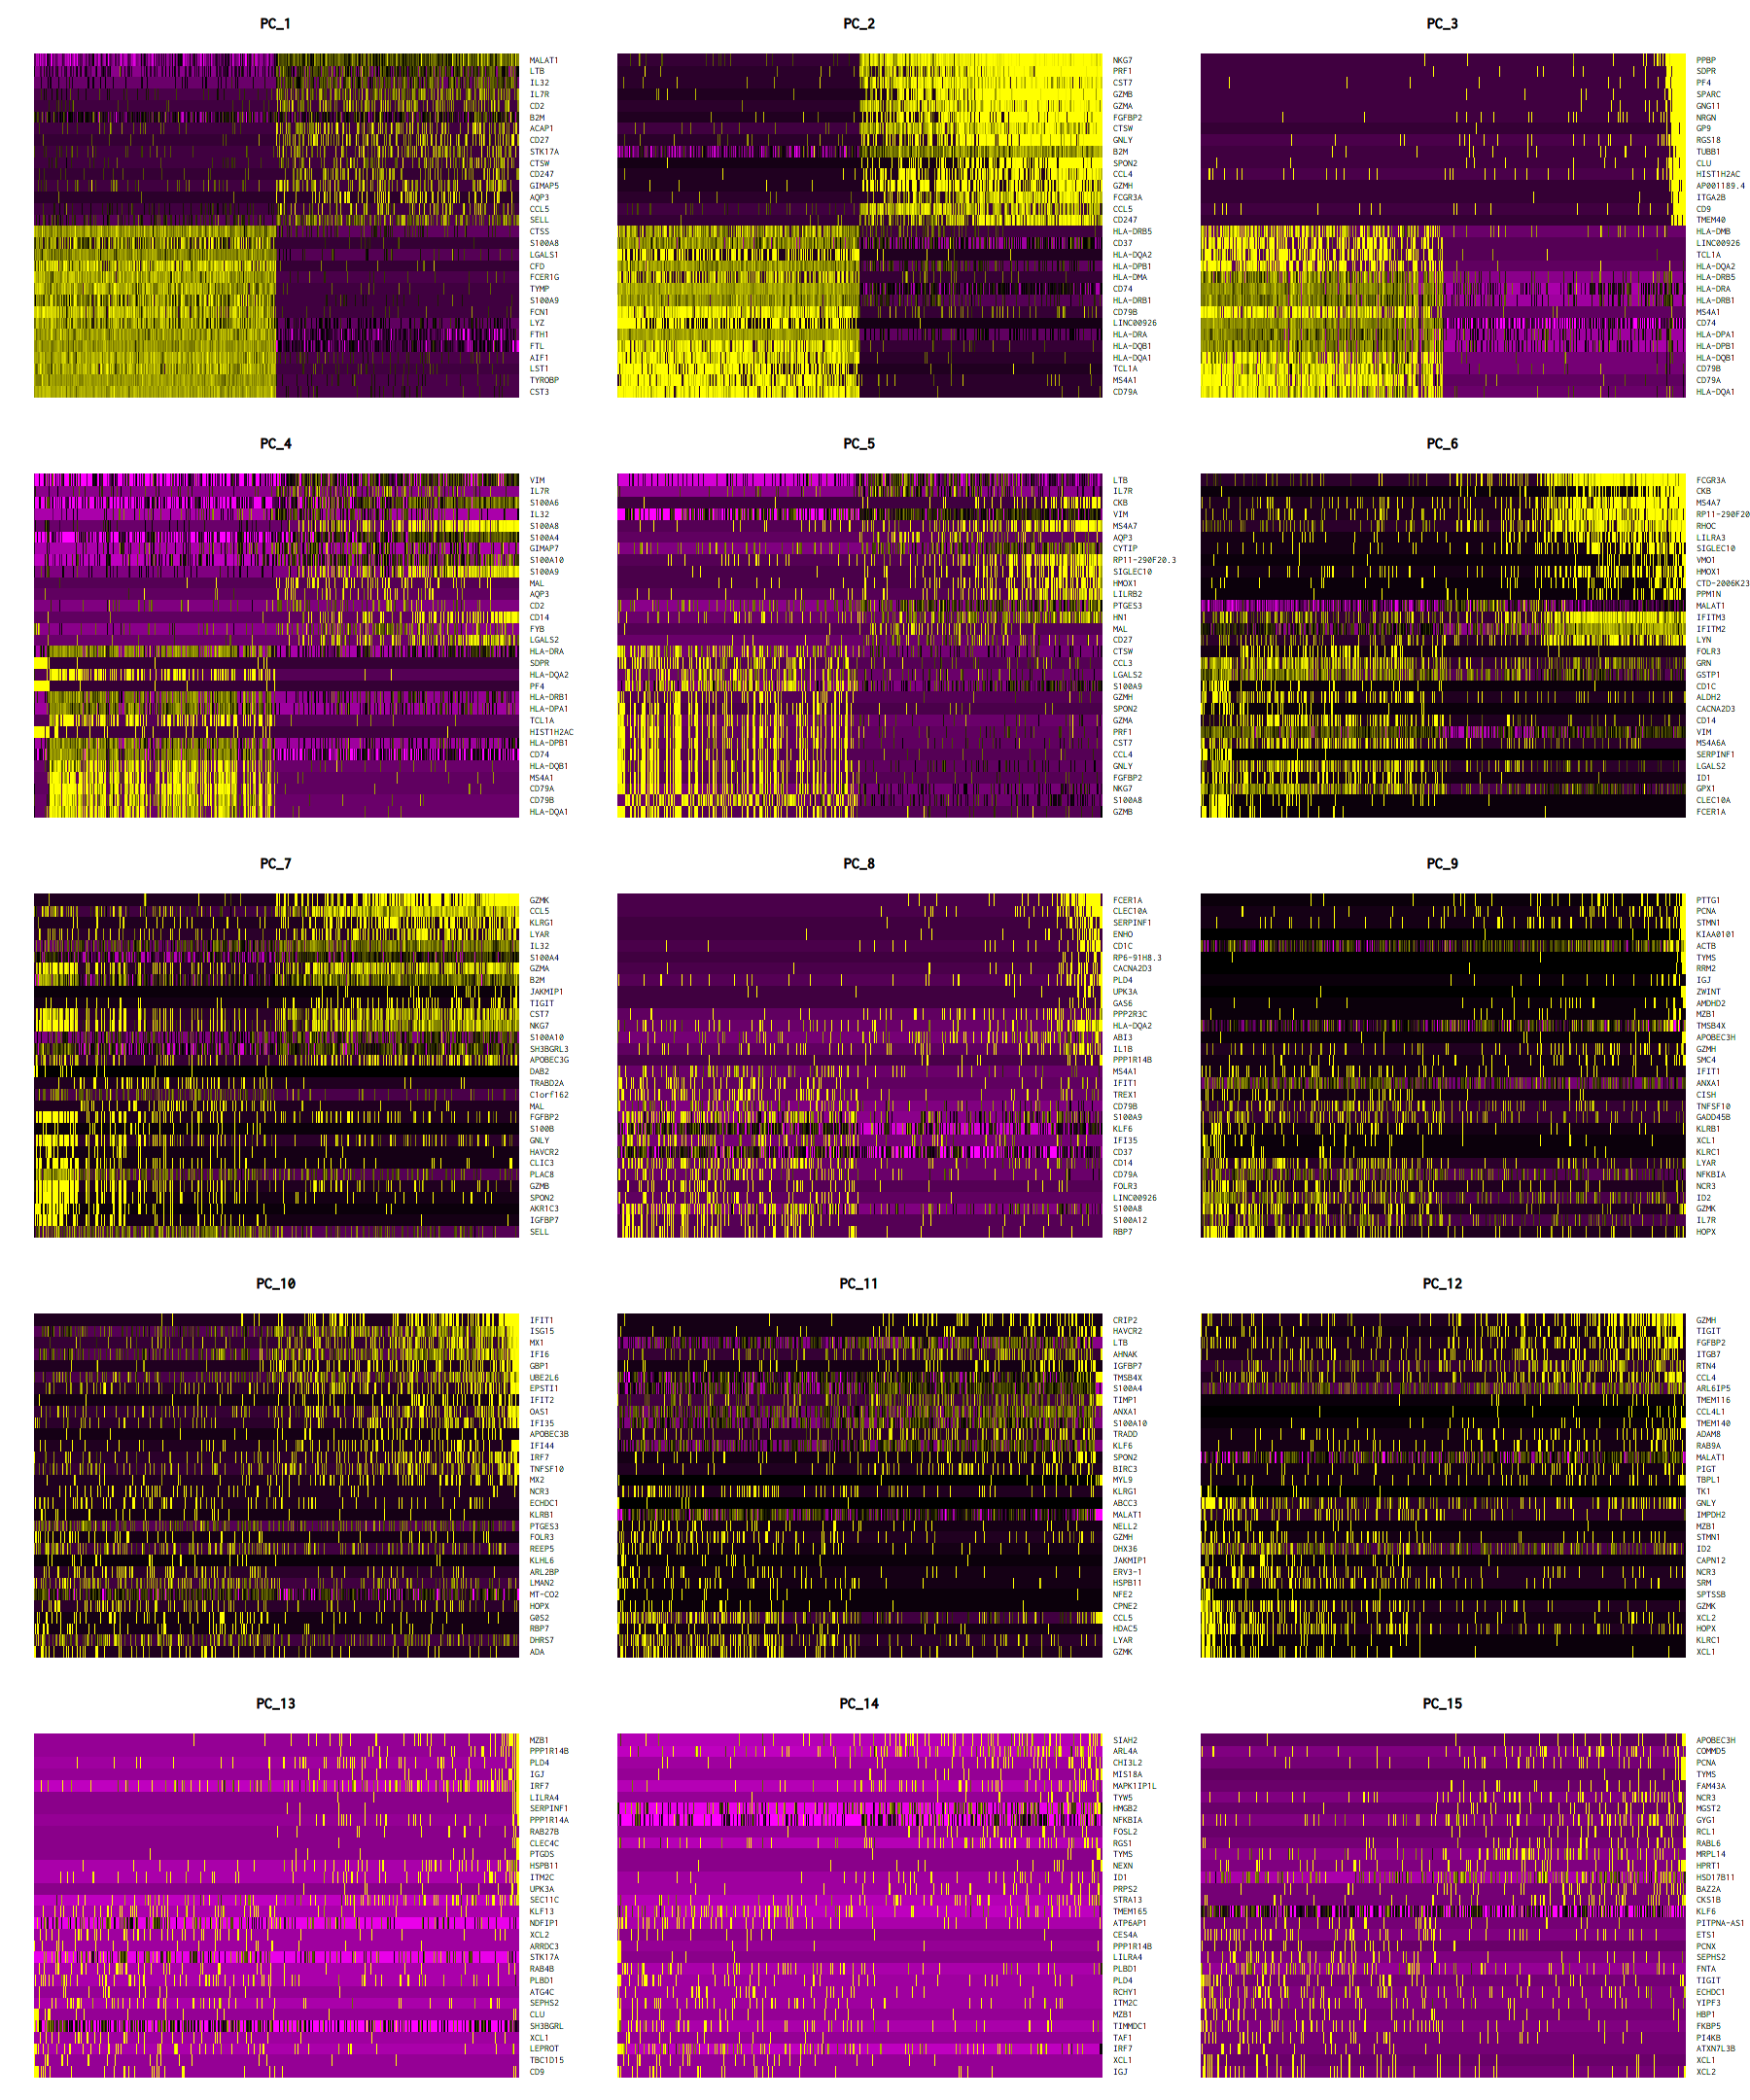

In [27]:
options(repr.plot.width = 15, repr.plot.height = 18)
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

#### Jack-Straw plotによる主成分の可視化
- 黒点線で示されたランダム状態より上に振れているほど情報量が多い
- （作成者注：このプロットは計算量が非常に多いです。その割に主観的で情報量は多くないので個人的にはスキップ推奨です。）

In [28]:
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23504 rows containing missing values (geom_point).”


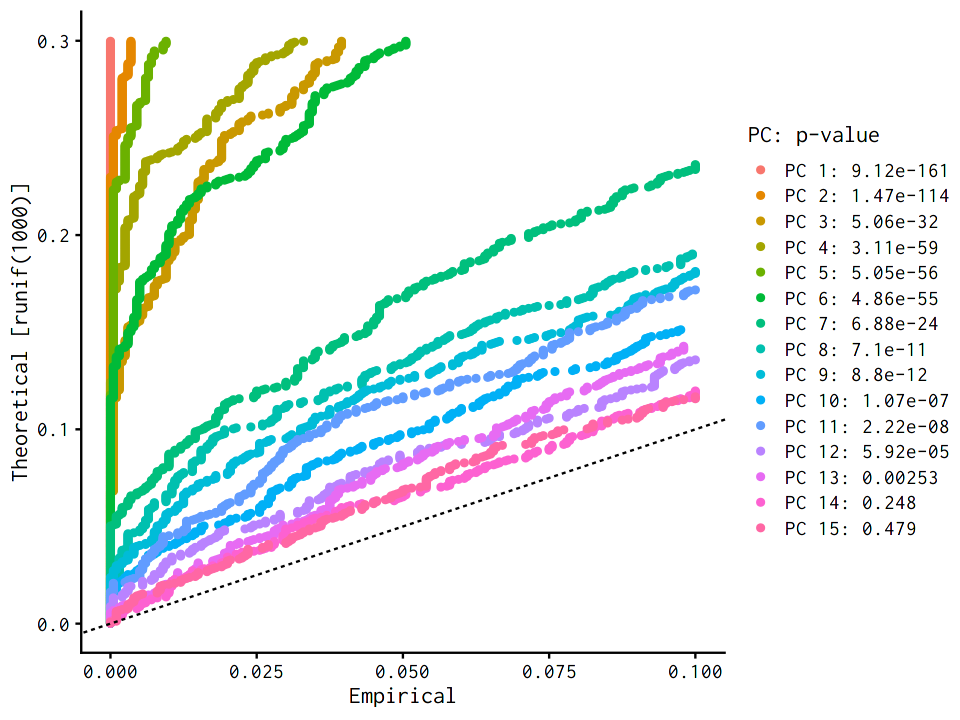

In [29]:
options(repr.plot.width = 8, repr.plot.height = 6)
JackStrawPlot(pbmc, dims = 1:15)

#### Elbow plotによる可視化
横軸が主成分の次元を表し、降下曲線から水平になる点（Elbow）が最適な主成分の次元数

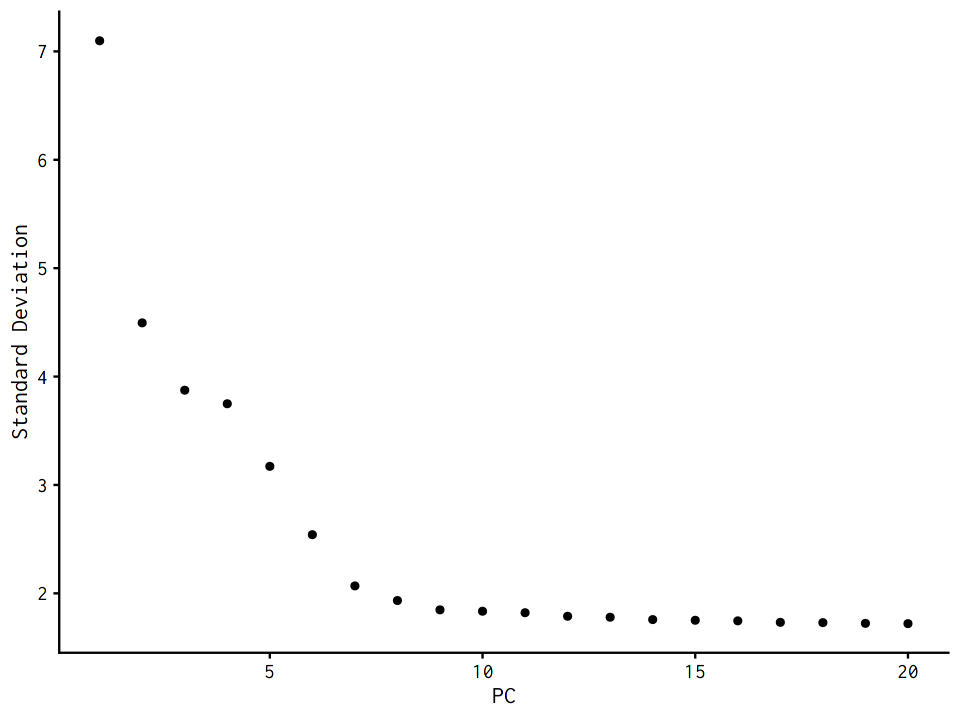

In [30]:
ElbowPlot(pbmc)

- 異なる数の主成分（10、15、あるいは50）で下流解析を繰り返してみましょう。結果は劇的には変わらないことが多いです。
- 主成分数を選択する際には、なるべく高い方に設定することをお勧めします。例えばPC5までで下流解析を行うと、結果に重大な悪影響を及ぼします。

## Clustering
- Seuratは v3から [PhenoGraph](https://pubmed.ncbi.nlm.nih.gov/26095251/)と同様に graph-based clustering approach を用いてクラスタリングするようになりました。 これはK近傍法（KNN）などを用いて近傍に存在する細胞同士をつないでグラフ構造にし、相互に高度に連結した部分細胞群（「準クリーク」または 「コミュニティ」）をクラスタとして抽出する方法です。
- SeuratはPhenoGraphと同様に、まずPCA空間でのユークリッド距離に基づいてK最近傍グラフを作成し、任意の2細胞について、2細胞間の全エッジの重なり（Jaccard類似度）に基づいて２細胞間のエッジの重みを調整します。このステップは`FindNeighbors`関数を使用して実行されます。
- （作成者注：従って、クラスタリング結果はtSNE, UMAPどちらを使うかには依存しません。）
- 細胞のクラスタリングにはLouvain algorithm (default) または SLM が用いられます。`FindClusters`関数がこれを行います。クラスタ数を直接指定することはできず、`resolution` を指定することでクラスタ数が変化します（値が大きいほどクラスタの数が多くなる）。
- このPBMCデータに対しては、`resolution`パラメータを0.4-1.2の間に設定すると良い結果が得られました。最適なresolution値はより大きなデータセットではしばしば増加します。クラスターは`Idents`関数を使って見つけることができます。得られたクラスタ数は "Number of communities" に表示されます。

In [31]:
# 第10主成分までの値を元にKNNグラフ作成
pbmc <- FindNeighbors(pbmc, dims = 1:10)

# KNNグラフを元にクラスタリング (resolutionを変えるとクラスタ数が変わる)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95843

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8722
Number of communities: 9
Elapsed time: 1 seconds


In [32]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               1                3                1                2 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## 次元削減

細胞を2次元上でプロットするため、tSNEやUMAPを用いて2次元に**次元削減**します。
tSNE, UMAPの入力は上の作業で得られたPCA主成分です。クラスタリングで得られたクラスタ内の細胞が近傍同士に配置されるよう、クラスタリングの入力と同じPCA主成分を使用しなければなりません（ここでは第10主成分まで）。


### tSNE

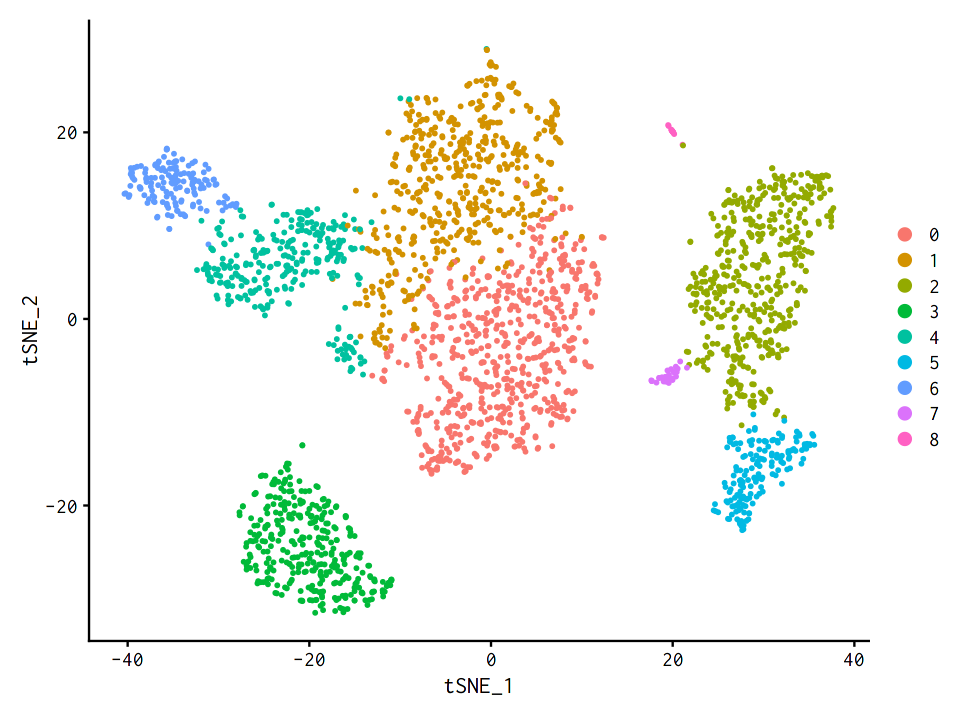

In [33]:
pbmc <- RunTSNE(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "tsne")

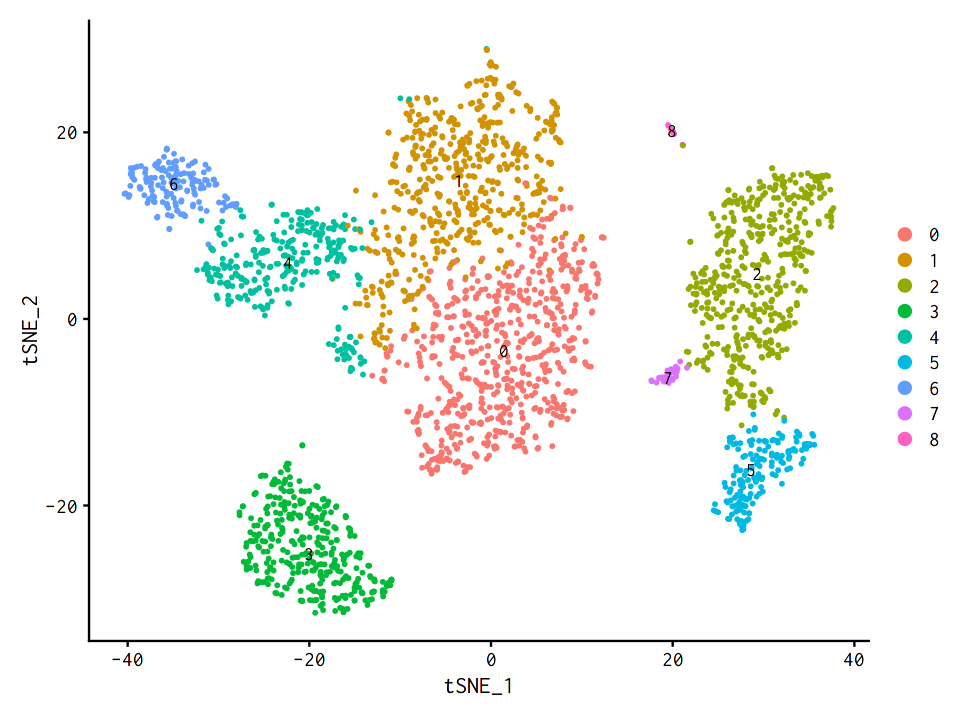

In [34]:
# "label = TRUE" をつけると細胞ラベルありになる
DimPlot(pbmc, reduction = "tsne", label = TRUE)

### UMAP

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:32:16 UMAP embedding parameters a = 0.9922 b = 1.112

17:32:16 Read 2638 rows and found 10 numeric columns

17:32:16 Using Annoy for neighbor search, n_neighbors = 30

17:32:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:32:21 Writing NN index file to temp file /tmp/Rtmpqa7NWp/file6d426a38f87b

17:32:21 Searching Annoy index using 1 thread, search_k = 3000

17:32:29 Annoy recall = 100%

17:32:32 Commencing smooth kNN distance calibration using 1 thread

17:32:39 Initializing fro

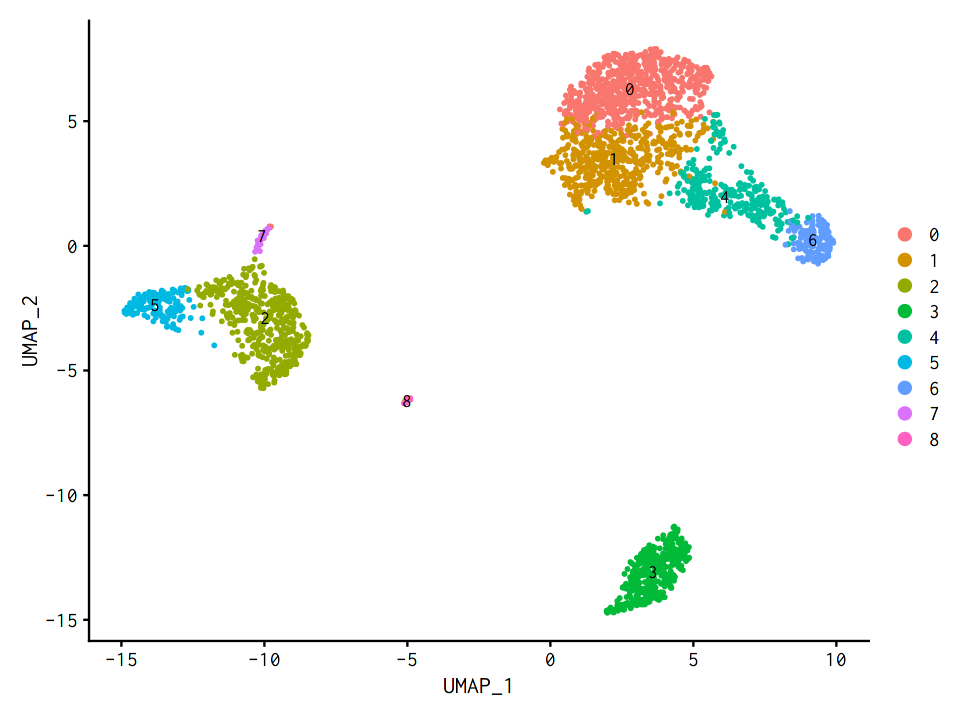

In [35]:
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap", label = TRUE)

### （optional）データ保存
ここまでの作業を毎回繰り返さなくてもよいように、pbmcオブジェクトをファイルとして出力することができます。

In [36]:
# データ保存
saveRDS(pbmc, file = "pbmc_tutorial.rds")

In [37]:
# 保存したデータを後から読み込む場合
# pbmc <- readRDS("pbmc_tutorial.rds")

## Sleepwalkを用いた細胞間発現類似度の可視化
PCAは線形変換のため高次元上での距離がある程度保存されますが、tSNE, UMAPは非線形変換であるため、高次元での相対的な距離やばらつきが保存されません。それを確認するために、[Sleepwalk](https://anders-biostat.github.io/sleepwalk/)というツールを用いて類似度を可視化したいと思います。

In [38]:
# ライブラリ読み込み
library(sleepwalk)

In [39]:
# pbmcオブジェクトが格納している次元データの確認
pbmc@reductions

$pca
A dimensional reduction object with key PC_ 
 Number of dimensions: 50 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: TRUE 
 Computed using assay: RNA 

$tsne
A dimensional reduction object with key tSNE_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 

$umap
A dimensional reduction object with key UMAP_ 
 Number of dimensions: 2 
 Projected dimensional reduction calculated:  FALSE 
 Jackstraw run: FALSE 
 Computed using assay: RNA 


In [40]:
# 以下のコマンドを実行し、生成された"sleepwalk.html"をブラウザで開いてください。
sleepwalk(list(pbmc@reductions$pca@cell.embeddings[,1:2],
               pbmc@reductions$tsne@cell.embeddings,
               pbmc@reductions$umap@cell.embeddings),
          pbmc@reductions$pca@cell.embeddings,
          saveToFile="sleepwalk.html")

Estimating 'maxdist' for feature matrix 1



得られたhtmlファイルの例は[こちら](./sleepwalk.html)から見ることができます。

カーソルを置いた細胞と発現類似度が高い細胞を各次元削減手法で同時に可視化することが可能です。

## 発現変動解析（クラスタごとのマーカ遺伝子抽出）

得られたクラスタごとに特徴的に発現している遺伝子を同定します。
`min.pct`引数は、比較する2群のいずれかで、この割合以上の細胞数が発現している遺伝子のみを対象とする閾値です。
`thresh.test`引数は、特徴が2つのグループ間で（平均的に）ある程度の差を持って発現していることを要求します。

- 作成者注：原理的にはクラスタ特異的に発現が失われている遺伝子も含みますが、実際には発現上昇遺伝子のみが対象にされることが多いです。
- 作成者注２：クラスタは通常３つ以上生成されますが、Seuratでは特定のクラスタと、それ以外の全てのクラスタでの２群間比較を行います。その結果、２つのクラスタにまたがって高発現している遺伝子などは抽出されにくくなっていると思われます。

In [42]:
# クラスタ1に特異的な遺伝子の抽出

cluster1.markers <- FindMarkers(pbmc, ident.1 = 1, min.pct = 0.25)
head(cluster1.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IL32,7.963064e-102,1.2590496,0.949,0.456,1.092055e-97
LTB,7.690348e-92,1.2803914,0.977,0.638,1.054654e-87
CD3D,7.770167e-77,0.9678333,0.918,0.424,1.065601e-72
LDHB,1.276785e-67,0.8822640,0.936,0.612,1.750983e-63
IL7R,4.822848e-67,1.1640305,0.729,0.324,6.614054e-63


利用できる発現変動解析法は複数あります。詳細：https://satijalab.org/seurat/articles/de_vignette.html

In [43]:
cluster1.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

In [41]:
# クラスタ0, 3に対して、クラスタ5で有意に変動している遺伝子の抽出
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,1.503232e-201,4.272769,0.975,0.038,2.061532e-197
CFD,1.113563e-190,3.421544,0.938,0.036,1.527140e-186
IFITM3,1.609194e-190,3.870255,0.975,0.049,2.206849e-186
CD68,1.649886e-185,3.012542,0.926,0.036,2.262654e-181
RP11-290F20.3,1.408433e-180,2.716446,0.840,0.017,1.931525e-176


`FindAllMarkers` を使うと、全クラスタから一度に変動遺伝子を抽出できます。
`only.pos = TRUE` オプションをつけることで、高発現遺伝子のみが出力されます。

In [45]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.953049e-92,1.390891,0.464,0.109,2.678412e-88,0,CCR7
2.476123e-35,1.163925,0.263,0.082,3.395754e-31,0,LDLRAP1
7.963064e-102,1.259050,0.949,0.456,1.092055e-97,1,IL32
7.690348e-92,1.280391,0.977,0.638,1.054654e-87,1,LTB
0.000000e+00,5.570063,0.996,0.215,0.000000e+00,2,S100A9
0.000000e+00,5.477394,0.975,0.121,0.000000e+00,2,S100A8
0.000000e+00,4.310172,0.936,0.041,0.000000e+00,3,CD79A
9.481783e-271,3.591579,0.622,0.022,1.300332e-266,3,TCL1A
2.236620e-200,3.102183,0.979,0.234,3.067300e-196,4,CCL5


### 指定した遺伝子をクラスタごとに分けてviolin plot

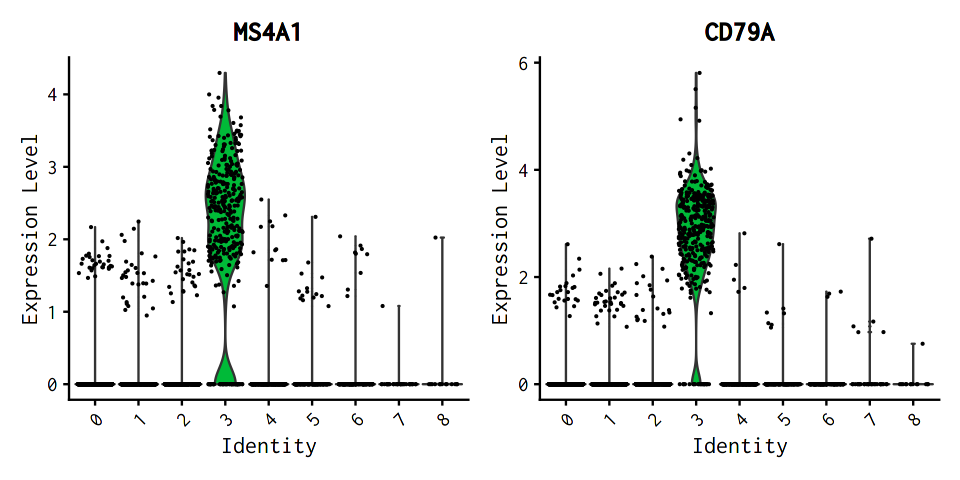

In [46]:
# violin plot (正規化後発現量)
options(repr.plot.width = 8, repr.plot.height = 4)
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

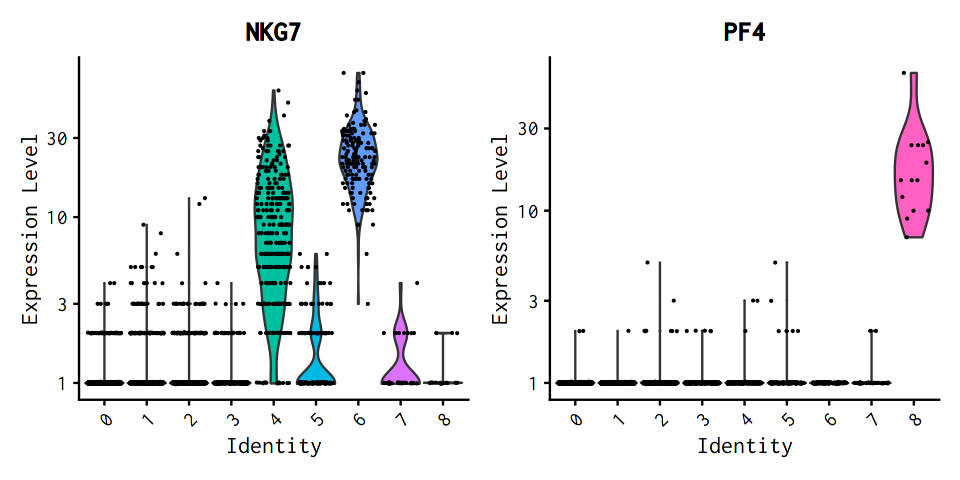

In [47]:
# raw counts (正規化前UMI数)
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

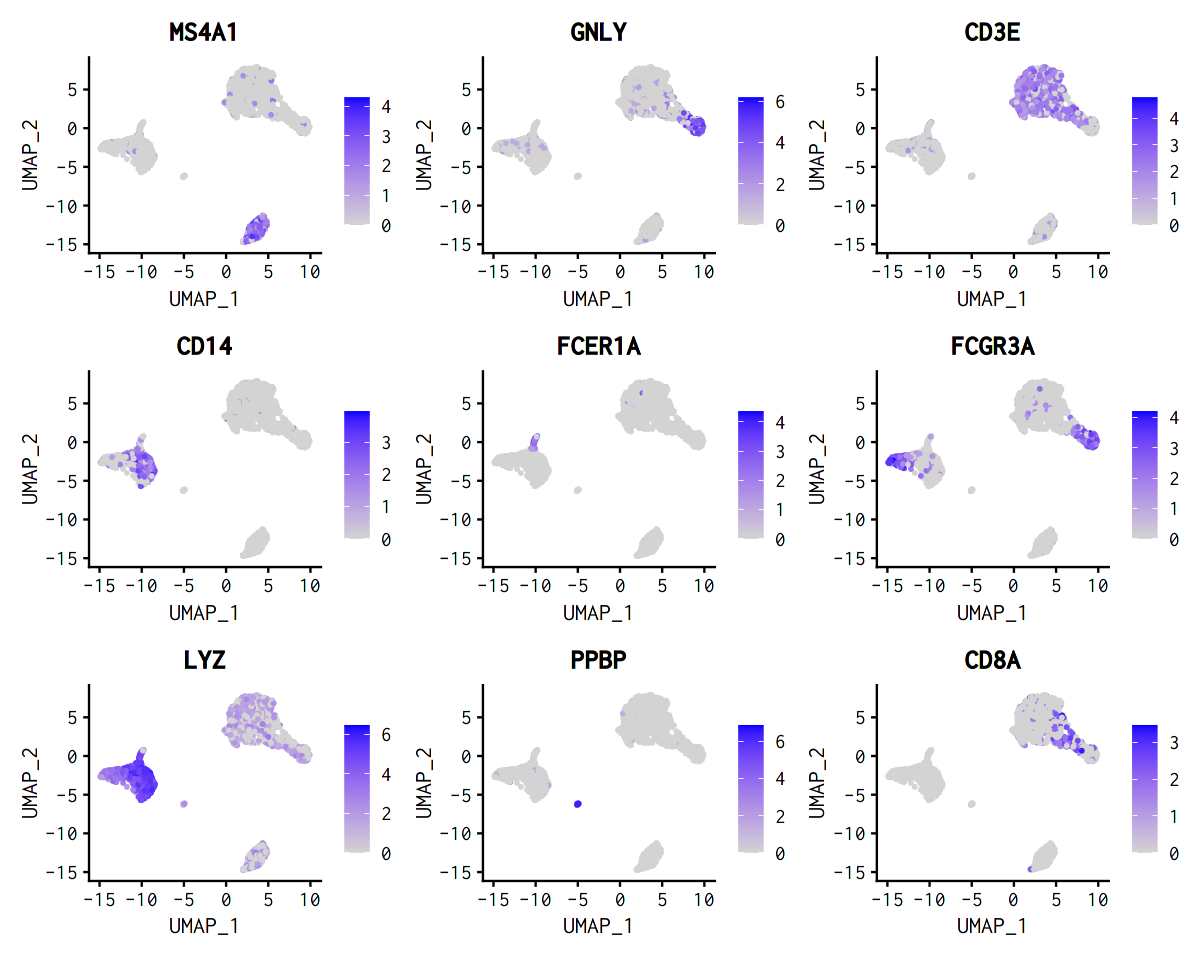

In [48]:
# UMAP (tSNE) プロット上で発現量を可視化
options(repr.plot.width = 10, repr.plot.height = 8)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

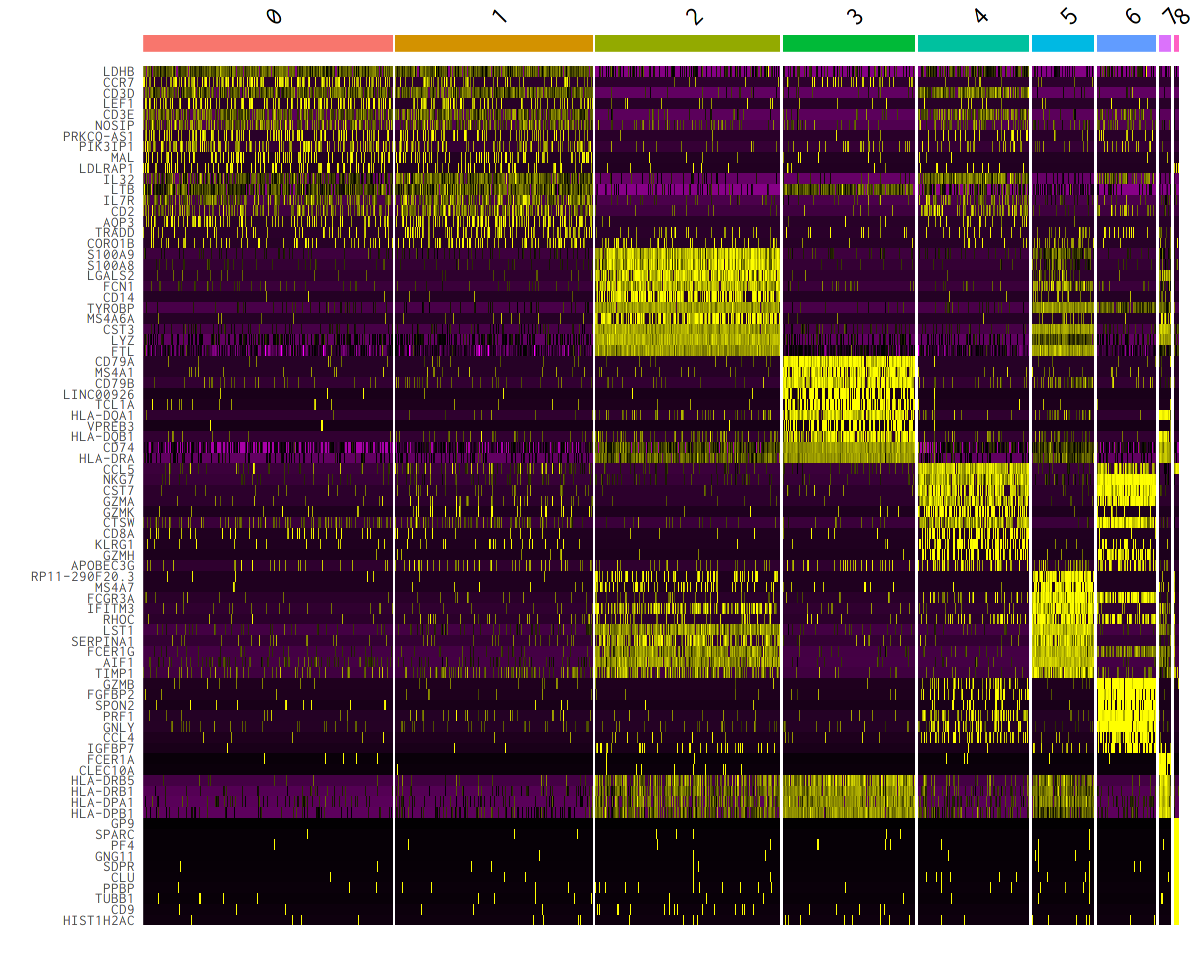

In [50]:
# Heatmap形式での発現量可視化
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

## クラスタのアノテーション (手作業でアノテートする場合)

上記の発現変動遺伝子の可視化により、各クラスタが何の細胞種であるか同定できたとします。以下のように細胞ラベルを付与して可視化することができます。

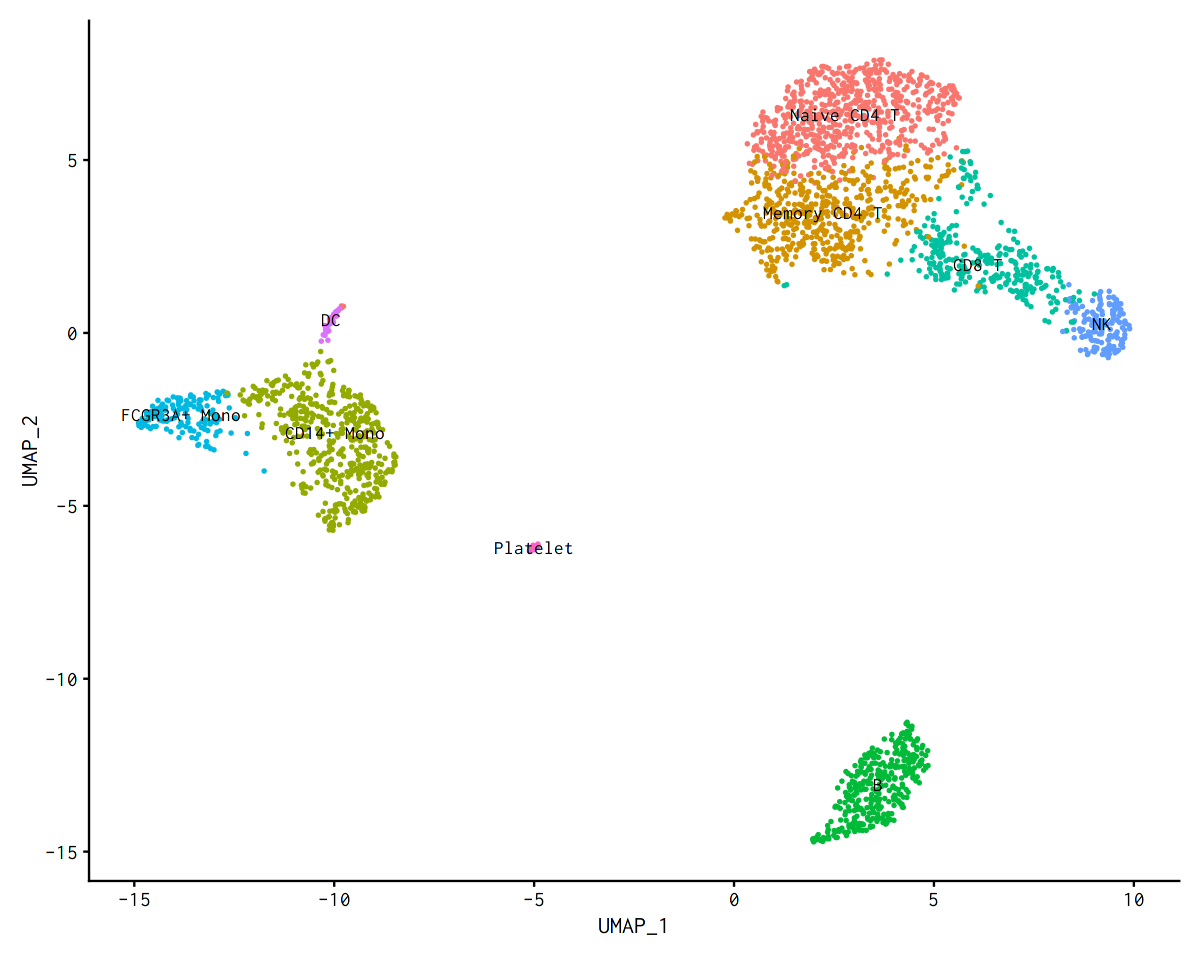

In [51]:
new.cluster.ids <- c("Naive CD4 T", "Memory CD4 T", "CD14+ Mono", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = "umap", label = TRUE, pt.size = 0.5) + NoLegend()

In [52]:
# データ保存
saveRDS(pbmc, file = "pbmc3k_final.rds")

## まとめ

- Seuratを使うことで、QC,フィルタリング、次元削減、クラスタリング、発現変動解析、可視化と一通りの作業は実行可能です。元URLのVinetteには他にも２サンプル間比較など様々な解析例が載っているので、参考にしてください。
- scATAC-seqでSeuratを使いたい場合は、Seuratの兄弟であるSignacを使うのがよいでしょう。
- 一方で、Seuratは軌道解析のための関数を持っていません。軌道解析を行いたい場合は[Monocle3](https://cole-trapnell-lab.github.io/monocle3/)など別のツールを使うか、[Seurat Wrappers](https://github.com/satijalab/seurat-wrappers)を使いましょう。

In [53]:
sessionInfo() 

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=ja_JP.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=ja_JP.UTF-8        LC_COLLATE=ja_JP.UTF-8    
 [5] LC_MONETARY=ja_JP.UTF-8    LC_MESSAGES=ja_JP.UTF-8   
 [7] LC_PAPER=ja_JP.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=ja_JP.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] sleepwalk_0.3.1    patchwork_1.1.1    SeuratObject_4.0.0 Seurat_4.0.0      
[5] dplyr_1.0.4       

loaded via a namespace (and not attached):
  [1] Rtsne_0.15           colorspace_2.0-0     deldir_0.2-9        
  [4] ellipsis_0.3.1       ggridges_0.5.3       IR